<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-07-27 06:22:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-07-27 06:22:25 (9.46 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [111]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [112]:
df.shape

(346, 10)

In [114]:
df.loan_status.value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

### Convert to date time object 

In [115]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [116]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [117]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

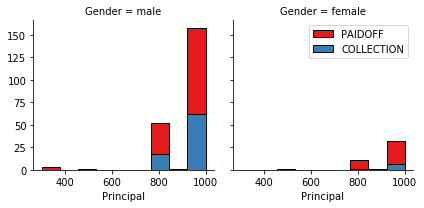

In [118]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

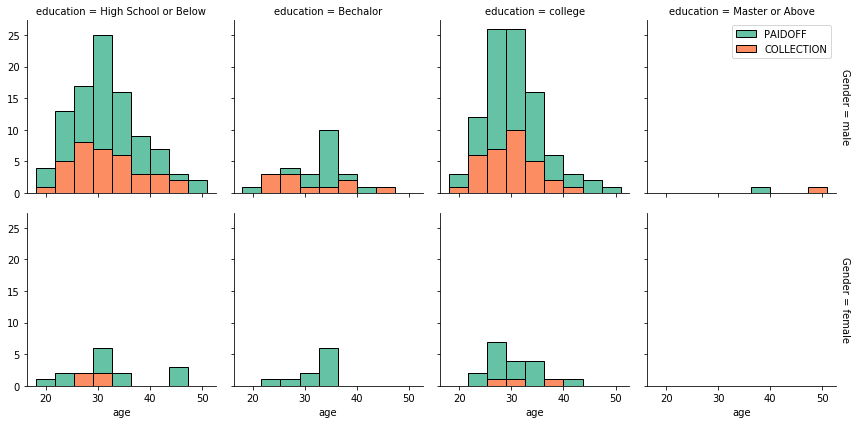

In [119]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="education", hue="loan_status", row ='Gender', margin_titles=True, palette="Set2")
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[0][-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

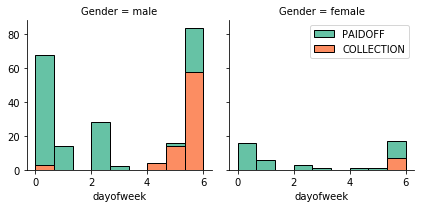

In [120]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [121]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


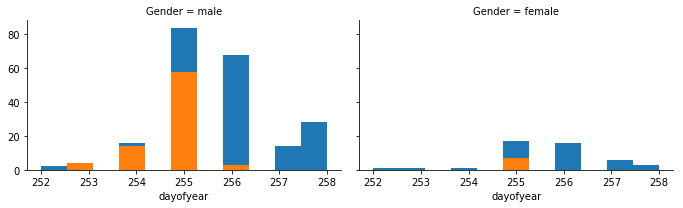

In [122]:
## Day of year
df["dayofyear"] = df["effective_date"].dt.dayofyear
bins = np.linspace(df.dayofyear.min(), df.dayofyear.max(), 12)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", aspect=1.6)
g.map(plt.hist,"dayofyear", bins=bins)

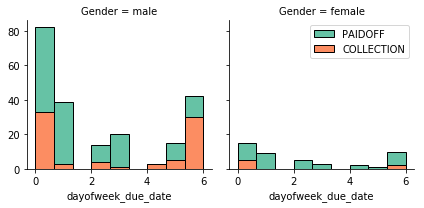

In [123]:
df['dayofweek_due_date'] = df['due_date'].dt.dayofweek
bins = np.linspace(df.dayofweek_due_date.min(), df.dayofweek_due_date.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'dayofweek_due_date', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [124]:
df['weekend_due_date'] = df['dayofweek_due_date'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,dayofyear,dayofweek_due_date,weekend_due_date
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0,252,4,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0,252,4,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0,252,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1,253,5,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1,253,5,1


## Convert Categorical features to numerical values

Lets look at gender:

In [125]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [126]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,dayofyear,dayofweek_due_date,weekend_due_date
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,252,4,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,252,4,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,252,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,253,5,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,253,5,1


## One Hot Encoding  
#### How about education?

In [127]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [128]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [129]:
Feature = df[['Principal','terms','age','Gender','weekend']] #,'weekend_due_date']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [130]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [131]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [132]:
X= preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

## Splitting the data into train and test set

In [133]:
from sklearn.metrics import log_loss, jaccard_similarity_score, f1_score
from sklearn.model_selection import train_test_split
# Splitting the data into train and test so as to train the model with best parameters
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

In [134]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(259, 8) (87, 8) (259,) (87,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Looping for 100 ks to find the model with best maximum accuracy

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
train_n_acc = []
test_n_acc = []
n=100
for k in range(1, n+1):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    train_n_acc.append(accuracy_score(y_train, neigh.predict(X_train)))
    test_n_acc.append(accuracy_score(y_test, neigh.predict(X_test)))

### Plotting the accuracy vs k

The Maximum Accuracy is  0.8735632183908046  achieved at k =  41


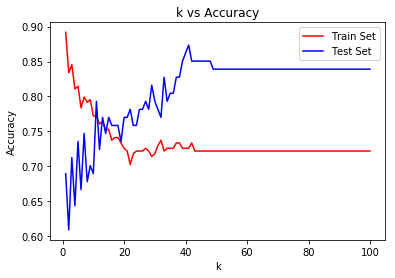

In [136]:
plt.plot(range(1,n+1), train_n_acc, c='red')
plt.plot(range(1,n+1), test_n_acc, c='blue')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.legend(('Train Set', 'Test Set'))
max_acc = max(test_n_acc)
k =  test_n_acc.index(max_acc)+1
print("The Maximum Accuracy is ", max_acc," achieved at k = ", k)

### Building the model with best k

In [137]:
ModelKNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

### Calculating accuracy score, f1 score and jaccard similarity score using the validation set

In [138]:
yhat = ModelKNN.predict(X_test)
print(accuracy_score(y_test, yhat), f1_score(y_test, yhat, average='weighted'), jaccard_similarity_score(y_test, yhat) )

0.8735632183908046 0.8370865148167767 0.8735632183908046


# Decision Tree

### FInding best depth using accuracy_score as a metrics on the splitted data

In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
n=10
train_n_acc = []
test_n_acc = []
for i in range(1,n+1):
    ModelDT = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    ModelDT.fit(X_train, y_train)
    train_n_acc.append(accuracy_score(y_train, ModelDT.predict(X_train)))
    test_n_acc.append(accuracy_score(y_test, ModelDT.predict(X_test)))

### Plotting depth vs accuracy

The Maximum Accuracy is  0.8390804597701149  achieved at depth =  1


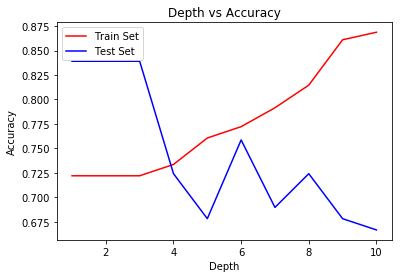

In [140]:
plt.plot(range(1, n+1), train_n_acc, c='red')
plt.plot(range(1, n+1), test_n_acc, c='blue')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Depth vs Accuracy')
plt.legend(('Train Set', 'Test Set'))
max_acc = max(test_n_acc)
depth =  test_n_acc.index(max_acc)+1
print("The Maximum Accuracy is ", max_acc," achieved at depth = ", depth)

### Training the model using the best depth found above.

In [141]:
ModelDT = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
ModelDT.fit(X_train, y_train)

0.8390804597701149 0.7656609195402299 0.8390804597701149


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### The final accuracy on the loan_test.csv is done at the last. Here is the metrics calculated using the splitted training data.

In [156]:
yhat = ModelDT.predict(X_test)
print(accuracy_score(y_test, yhat), f1_score(y_test, yhat, average='weighted'), jaccard_similarity_score(y_test, yhat) )

0.8390804597701149 0.7656609195402299 0.8390804597701149


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Support Vector Machine

### Looping through different kernels to find the best one

In [142]:
from sklearn import svm
train_ker_acc = []
test_ker_acc = []
kernels = ["rbf", "linear", "sigmoid", "poly"]
for ker in kernels:
    ModelSVM = svm.SVC(kernel=ker, gamma='auto')
    ModelSVM.fit(X_train, y_train)
    train_ker_acc.append(accuracy_score(y_train, ModelSVM.predict(X_train)))
    test_ker_acc.append(accuracy_score(y_test, ModelSVM.predict(X_test)))

### Plotting kernel vs accuracy

The Maximum Accuracy is  0.8390804597701149  achieved with kernel =  linear


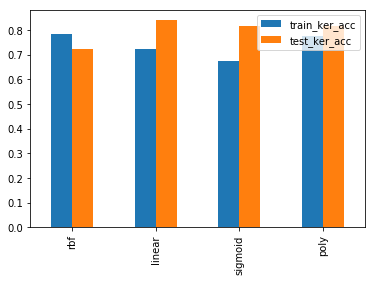

In [143]:
df=pd.DataFrame(np.c_[train_ker_acc,test_ker_acc], index=kernels, columns=["train_ker_acc","test_ker_acc"])
df.plot.bar()
kernel= df["test_ker_acc"].idxmax() 
max_acc = df.loc[kernel,"test_ker_acc"]
print("The Maximum Accuracy is ", max_acc," achieved with kernel = ", kernel)

In [144]:
ModelSVM = svm.SVC(kernel=kernel, gamma='auto')
ModelSVM.fit(X_train, y_train)

0.8390804597701149 0.7656609195402299 0.8390804597701149


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### The final accuracy on the loan_test.csv is done at the last. Here is the metrics calculated using the splitted training data

In [157]:
yhat = ModelSVM.predict(X_test)
print(accuracy_score(y_test, yhat), f1_score(y_test, yhat, average='weighted'), jaccard_similarity_score(y_test, yhat) )

0.8390804597701149 0.7656609195402299 0.8390804597701149


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Logistic Regression

In [145]:
from sklearn.linear_model import LogisticRegression
ModelLR = LogisticRegression(solver='lbfgs') #when of dayofweek_duedate flag is also used as a feature, it's accuracy goes to more than 0.85 
ModelLR.fit(X_train,y_train)
yhat = ModelLR.predict(X_test)
print(accuracy_score(y_test, yhat), f1_score(y_test, yhat, average='weighted'), jaccard_similarity_score(y_test, yhat), log_loss(y_test,ModelLR.predict_proba(X_test)) )

0.8390804597701149 0.8278160919540227 0.8390804597701149 0.37772885881883467


# Model Evaluation using Test set

First, download and load the test set:

In [147]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-07-27 06:54:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-07-27 06:54:16 (647 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [148]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Processing and tranforming the TEST data

In [149]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df["dayofweek"] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test["Gender"].replace(to_replace=['male', 'female'], value=[0,1],inplace=True)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head() #Principal	terms	age	Gender	weekend	Bechalor	High School or Below	college

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [150]:
X_TEST = Feature_test.values
y_TEST = test_df["loan_status"].values
y_TEST.shape, X_TEST.shape

((54,), (54, 8))

In [155]:
jaccard, f1 = [], []
for model in [ModelKNN, ModelDT,ModelSVM, ModelLR]:
    jaccard.append(jaccard_similarity_score(y_TEST, model.predict(X_TEST)))
    f1.append(f1_score(y_TEST, model.predict(X_TEST), average='weighted'))

ll =["NA"]*3 + [log_loss(y_TEST,ModelLR.predict_proba(X_TEST))]
report = pd.DataFrame({"Algorithm":["KNN", "Decision Tree", "SVM", "Logistic Regression"], 
                       "Jaccard":jaccard, 
                       "F1-score":f1, 
                       "LogLoss":ll })
report

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.740741,0.630418,NA
1,Decision Tree,0.740741,0.630418,NA
2,SVM,0.740741,0.630418,NA
3,Logistic Regression,0.740741,0.630418,7.57249


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>